In [1]:
import numpy as np
import os
import os.path
from PIL import Image
import matplotlib.pyplot as pyplot
from mpl_toolkits.mplot3d import Axes3D, proj3d
import matplotlib.lines as mlines
from pose_estimation_utils import *
import cv2
import cv
import scipy.spatial as scispat
%matplotlib notebook

In [3]:
# CV2 PNP test
objectPoints = np.random.random((10,3,1))
imagePoints = np.random.random((10,2,1))
cameraMatrix = np.eye(3)
distCoeffs = np.zeros((5,1))

# print(cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, distCoeffs))
# print(cv2.solvePnPRansac(objectPoints, imagePoints, cameraMatrix, distCoeffs))

In [2]:
"""
Function block: Display + I/O routines
"""
# Read file with 2D correspondences - custom format
def read_2d_correspondences(file_name, num_points):
    corres_2d = []
    with open(file_name, 'rb') as fp:
        for i in range(num_points):
            vals = str.split(fp.readline(),'\n')[0]
            corres_2d.append([str.split(vals, ' ')[0], str.split(vals, ' ')[1]])
    corres_2d = np.asarray(corres_2d, dtype='float32')
    return corres_2d


# Helper: Plots 2d landmarks
def plot_2d_landmarks(landmarks):
    pyplot.figure()
    pyplot.scatter(landmarks[:, 0], landmarks[:, 1], c='r')
    pyplot.axis('off')
    pyplot.title('Face landmarks in 2D')
    pyplot.gca().invert_yaxis()
    pyplot.show()


# Helper: Plots 3D landmarks
def plot_3d_landmarks(points):
    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r')
    ax.set_title('Face landmarks in 3D')
    pyplot.show()


# Helper: Normalize a rodrigues vector to get the axis of rotation
def rod_vec_to_rot_axis(r_vec):
    norm = np.sqrt(r_vec[0]**2 + r_vec[1]**2 + r_vec[2]**2)
    rot_axis = r_vec/norm
    return rot_axis


# Helper: Plots 3D landmarks with a camera
def plot_3d_landmarks_with_camera(points, camera_t, r_vec, method=''):
    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r')
    ax.scatter(camera_t[0], camera_t[1], camera_t[2], c='g', s=20)
    x, y, z = proj3d.proj_transform(camera_t[0], camera_t[1], camera_t[2], ax.get_proj())
    rot_axis = rod_vec_to_rot_axis(r_vec)
    rot_axis = rot_axis - camera_t
    cam_axis = np.concatenate((camera_t, rot_axis), axis=1)
    ax.plot(cam_axis[0, :], cam_axis[1, :], cam_axis[2, :], c='y')
    ax.scatter(cam_axis[0, 1], cam_axis[1, 1], cam_axis[2, 1], marker="^")
    ax.annotate('camera', xy=(x, y))
    pyplot.title('Estimated camera fit: ' + method)
    pyplot.show()


# Helper: Plot 2 sets of 3D landmarks and a camera, side by side to compare.
def plot_compare_3d_landmarks(points1, points2, cam, r_vec, method=''):
    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points1[:, 0], points1[:, 1], points1[:, 2], c='r')
    ax.scatter(points2[:, 0], points2[:, 1], points2[:, 2], c='b')
    ax.scatter(cam[0], cam[1], cam[2], c='g', s=20)
    x, y, z = proj3d.proj_transform(cam[0], cam[1], cam[2], ax.get_proj())
    rod_vec = rod_vec_to_rot_axis(r_vec)
    rod_vec = rod_vec - cam
    cam_axis = np.concatenate((cam, rod_vec), axis=1)
    ax.plot(cam_axis[0, :], cam_axis[1, :], cam_axis[2, :], c='y')
    ax.scatter(cam_axis[0, 1], cam_axis[1, 1], cam_axis[2, 1], marker="^")
    ax.annotate('camera', xy=(x, y))
    pyplot.title('Estimated camera fit: ' + method)
    red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='Before transformation')
    blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='After transformation')
    pyplot.legend(handles=[red_line, blue_line], loc=3, borderaxespad=0)
    pyplot.show()

# Helper: Plot a 3D landmarks along with two different cameras for comparison.
def plot_compare_3d_cameras(points, cam1, r_vec1, cam2, r_vec2, method=''):
    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r')
    ax.scatter(cam1[0], cam1[1], cam1[2], c='g', s=20)
    ax.scatter(cam2[0], cam2[1], cam2[2], c='b', s=20)
    # Camera 1
    rod_vec1 = rod_vec_to_rot_axis(r_vec1)
    rod_vec1 = rod_vec1 - cam1
    cam_axis1 = np.concatenate((cam1, rod_vec1), axis=1)
    ax.plot(cam_axis1[0, :], cam_axis1[1, :], cam_axis1[2, :], c='g')
    ax.scatter(cam_axis1[0, 1], cam_axis1[1, 1], cam_axis1[2, 1], marker="^")
    x1, y1, z1 = proj3d.proj_transform(cam1[0], cam1[1], cam1[2], ax.get_proj())
    ax.annotate('camera original', xy=(x1, y1))
    # Camera 2
    rod_vec2 = rod_vec_to_rot_axis(r_vec2)
    rod_vec2 = rod_vec2 - cam2
    cam_axis2 = np.concatenate((cam2, rod_vec2), axis=1)
    ax.plot(cam_axis2[0, :], cam_axis2[1, :], cam_axis2[2, :], c='b')
    ax.scatter(cam_axis2[0, 1], cam_axis2[1, 1], cam_axis2[2, 1], marker="^")
    x2, y2, z2 = proj3d.proj_transform(cam2[0], cam2[1], cam2[2], ax.get_proj())
    ax.annotate('camera new', xy=(x2, y2))

    pyplot.title('Estimated camera fit: ' + method)
    red_line = mlines.Line2D([], [], color='green', marker='o',
                          markersize=15, label='camera original')
    b_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='camera new')
    pyplot.legend(handles=[red_line, b_line], loc=3, borderaxespad=0)
    pyplot.show()

<IPython.core.display.Javascript object>


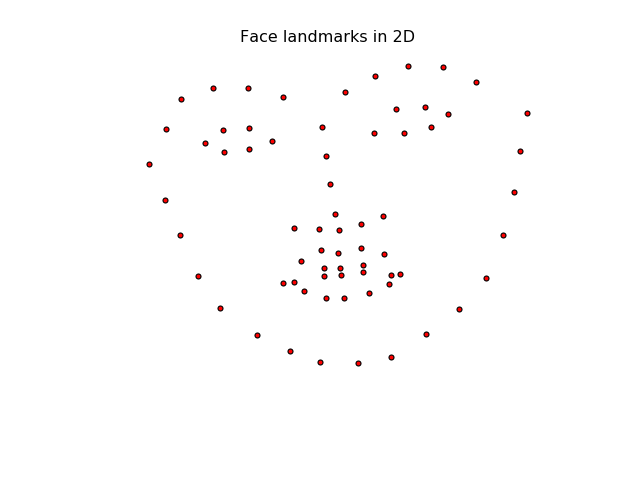

<IPython.core.display.Javascript object>


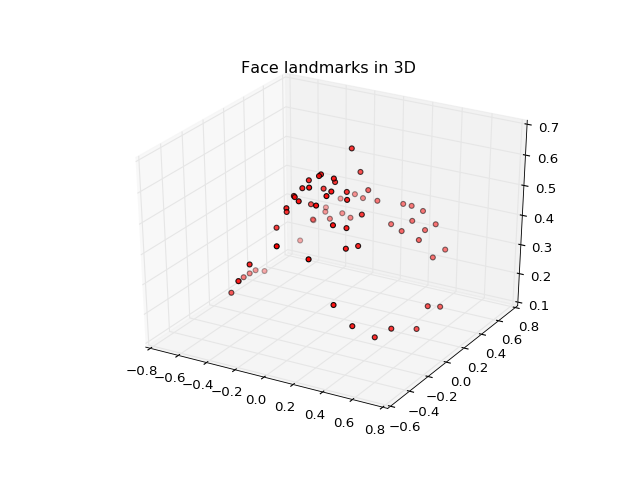

In [3]:
"""
Step 1.0: Read 3D object and 2D image correspondences.
"""
points_2D_file = '../data/2d_locs.pts'
points_3D_file = '../data/3D-models/68-landmark-points'
num_landmarks = 68
# dimension: num_landmarks x 2
corres_2d = read_2d_correspondences(points_2D_file, num_landmarks)
# dimension: num_landmarks x 3
corres_3d = np.asarray(read_3d_points(points_3D_file), dtype='float32')
# corres_3d[:, 2] = -(corres_3d[:, 2])

plot_2d_landmarks(corres_2d)
plot_3d_landmarks(corres_3d)

In [4]:
"""
Function block: Bunch of functions that estimate and manipulate camera parameters
"""
def estimate_camera_opencv_solver(objs, imgs, cmat, distortionc):
    ret, rot_vec, t_vec = cv2.solvePnP(objs, imgs, cmat, distortionc)
    return rot_vec, t_vec

def estimate_camera_opencv_calib(objs, imgs, imgsize, cmat, dist):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([objs], [imgs], imgsize, cmat, dist,
                                                      flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    return mtx[:], rvecs[0], tvecs[0], dist[0]

def estimate_camera_opencv_ransac(objs, imgs, cmat, distc):
    rvec, tvec, _ = cv2.solvePnPRansac(objs, imgs, cmat, distc, iterationsCount=150, reprojectionError=2.5)
    return rvec, tvec

def print_camera(est, mat, rvec, tvec, dist):
    print('Method: ')
    print(est)
    print('Camera Matrix:')
    print(mat)
    print('Rotation vector:')
    print(rvec)
    print('Translation vector:')
    print(tvec)
    print('Distortion:')
    print(dist)

# Helper: Reprojects points through a camera, estimates total and mean reprojection error
def calculate_reprojection_error(cmat, rvec, tvec, dist, obj, img, num_pts):
    tot_error = 0
    mean_error = 0
    proj, j = cv2.projectPoints(obj, rvec, tvec, cmat, dist)
    proj = np.reshape(proj, (num_pts, 2))
    error = cv2.norm(img, proj, cv2.NORM_L2)/len(proj)
    tot_error += error
    mean_error = tot_error/num_pts
    return proj, tot_error, mean_error

# Camera transform - translation
def ct_translate(points_3d, t_vec):
    num_points = points_3d.shape[0]
    result = np.array(points_3d)
    for i in range(num_points):
        result[i, :] += t_vec
    return result

# Camera transform - Rotation
def ct_rotate(points_3d, x_deg, y_deg, z_deg):
    rx = np.zeros((3, 3), dtype='float32')
    ry = np.zeros((3, 3), dtype='float32')
    rz = np.zeros((3, 3), dtype='float32')
    
    # rotate by z_deg
    rz[0, 0] = np.cos((z_deg*np.pi)/180)
    rz[1, 1] = rz[0, 0]
    rz[1, 0] = np.sin((z_deg*np.pi)/180)
    rz[0, 1] = -(rz[1, 0])
    rz[2, 2] = 1
    
    # rotate by y_deg
    ry[1, 1] = 1
    ry[0, 0] = np.cos((y_deg*np.pi)/180)
    ry[2, 2] = rz[0, 0]
    ry[0, 2] = np.sin((y_deg*np.pi)/180)
    ry[2, 0] = -(rz[0, 2])
    
    # rotate by x_deg
    rx[0, 0] = 1
    rx[1, 1] = np.cos((x_deg*np.pi)/180)
    rx[2, 2] = rx[1, 1]
    rx[2, 1] = np.sin((x_deg*np.pi)/180)
    rx[1, 2] = -(rx[2, 1])
    
    # Composite rotation matrix
    cr = np.dot(rz, np.dot(rx, ry))
#     print(rz, ry, rx)
    
    result = np.array(points_3d)
    num_pts = result.shape[0]
    for i in range(num_pts):
        result[i, :] = np.matmul(cr, result[i])
    return result

In [5]:
"""
Function block: More display routines. For images, landmarks etc.
"""
def show_image(image):
    fig = pyplot.figure()
    fig = pyplot.imshow(image)
    pyplot.axis('off')
    pyplot.show()

def show_image_with_landmarks(image, landmarks):
    fig = pyplot.figure()
    pyplot.imshow(image)
    pyplot.scatter(landmarks[:, 0], landmarks[:, 1], s=20, c='r')
    pyplot.axis('off')
    pyplot.show()

def show_only_landmarks(landmarks):
    pyplot.figure()
    pyplot.scatter(landmarks[:, 0], landmarks[:, 1], s=20, c='r')
    pyplot.show()

def show_flow_field(field):
#     im = np.sqrt((field[:, :, 0] * field[:, :, 0]) + (field[:, :, 1] * field[:, :, 1]))
#     im = Image.fromarray(im, 'RGB')
    fig = pyplot.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(field[:, :, 0], origin='upper')
    ax1.set_title('Horizontal Flow')
#     pyplot.gca().invert_yaxis()
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(field[:, :, 1], origin='upper')
    ax2.set_title('Vertifcal Flow')
#     pyplot.gca().invert_yaxis()
    pyplot.show()

Image Dimensions:
(742, 521, 3)


<IPython.core.display.Javascript object>


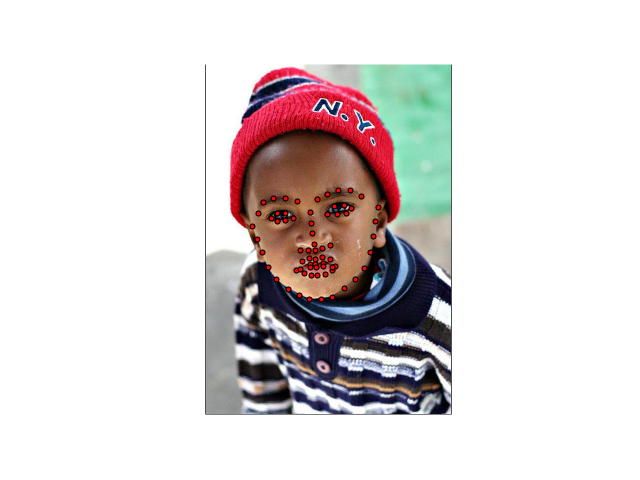

In [6]:
"""
Step 1.1: Read a test image
"""
face = Image.open('../data/test_1.jpg')
f = np.asarray(face)
print('Image Dimensions:')
print(f.shape)
# test image with ground truth landmarks
show_image_with_landmarks(f, corres_2d)

<IPython.core.display.Javascript object>


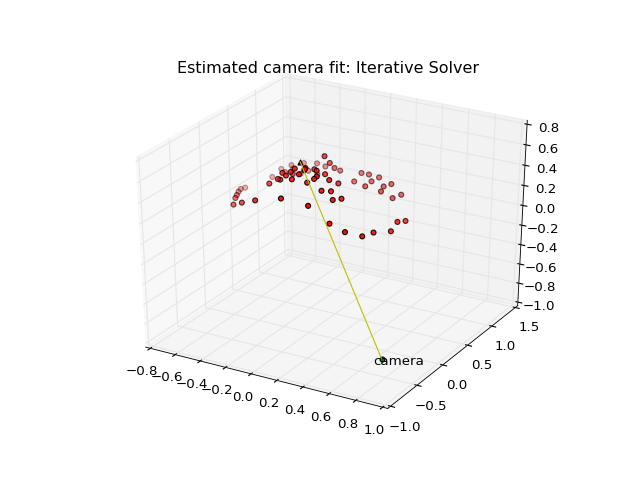

<IPython.core.display.Javascript object>


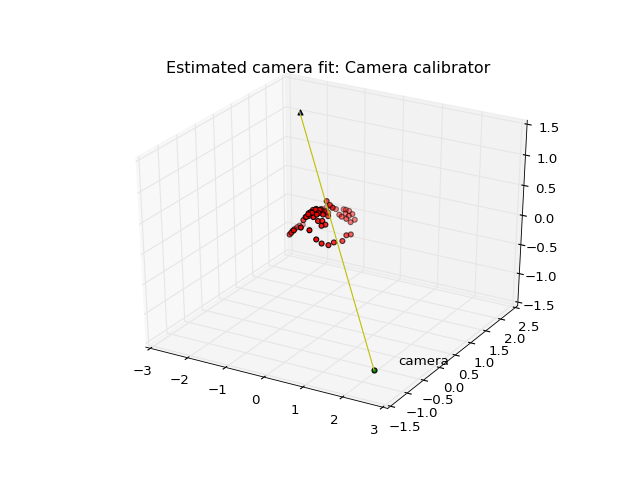

<IPython.core.display.Javascript object>


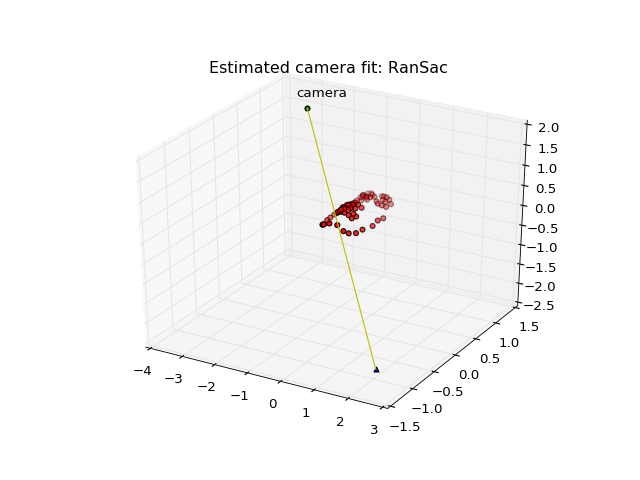

In [7]:
"""
Step 2: Estimate the camera intrinsics and extrinsics from the list of correspondences. 

camera intrinsics:
1. Focal length f
2. Principal point (x0, y0)

camera extrinsics:
1. Rotation vector (3 degrees of freedom)
2. Translation vector (3 degrees of freedom)
3. Distortion coefficients (5)

Initialization:
Since we are dealing with images of faces, a 55mm focal length is a reasonable assumption. The principal
point of the camera is the centre of the image (width/2, height/2). Note that these values are not fixed and
will be changed by the optimizer.

| 55, 0 , width/2  |
| 0,  55, height/2 |
| 0,  0,  1        |
"""

cameraMatrix = np.eye(3)
cameraMatrix[0][0] = 55
cameraMatrix[1][1] = 55
cameraMatrix[0][2] = f.shape[0]/2+1
cameraMatrix[1][2] = f.shape[1]/2+1
distCoeffs = np.zeros((5, 1))
cmat_copy = cameraMatrix
dc_copy = distCoeffs

# Iterative solver: Estimates extrinsics and updates intrinsics
rvec_solver, tvec_solver = estimate_camera_opencv_solver(corres_3d, corres_2d, cmat_copy,
                                                        dc_copy)
# Camera calibrator: Estimates both extrinsics and intrinsics
cmat_cc, rvec_cc, tvec_cc, dist_cc = estimate_camera_opencv_calib(corres_3d, corres_2d,
                                                                 (740, 512), cameraMatrix,
                                                                 distCoeffs)
# RanSac iterative solver: Estimates extrinsics and updates intrinsics
rvec_ran, tvec_ran = estimate_camera_opencv_ransac(corres_3d, corres_2d, cmat_copy, dc_copy)
# print_camera('Iterative Solver', cmat_copy, rvec_solver, tvec_solver, distCoeffs)
# print_camera('Camera Calibrator', cmat_cc, rvec_cc, tvec_cc, dist_cc)
# print_camera('Ransac', cmat_copy, rvec_ran, tvec_ran, dc_copy)
plot_3d_landmarks_with_camera(corres_3d, tvec_solver, rvec_solver, 'Iterative Solver')
plot_3d_landmarks_with_camera(corres_3d, tvec_cc, rvec_cc, 'Camera calibrator')
plot_3d_landmarks_with_camera(corres_3d, tvec_ran, rvec_ran, 'RanSac')

Iterative solver:
('Total error: ', 63.560182876472616, 'Mean error: ', 0.9347085717128326)


<IPython.core.display.Javascript object>


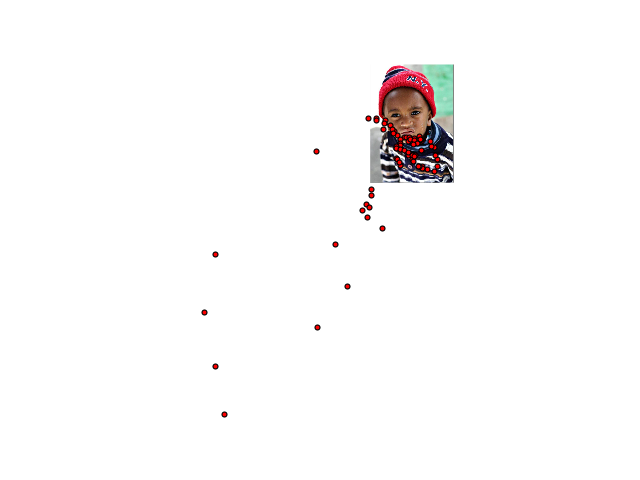

Camera calibrator:
('Total error: ', 1.4235007887660618, 'Mean error: ', 0.020933835128912674)


<IPython.core.display.Javascript object>


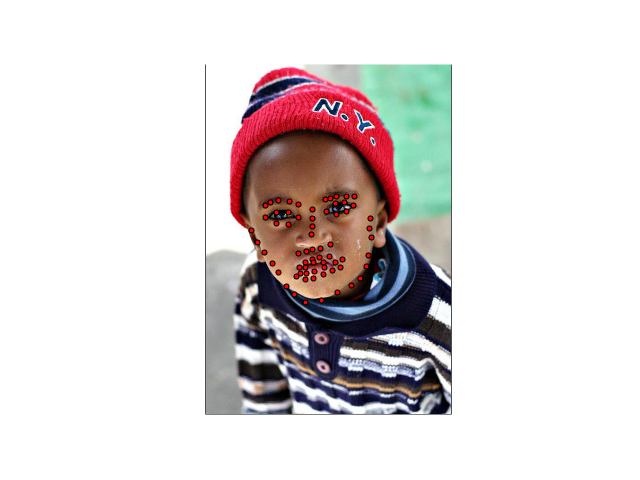

RanSac:
('Total error: ', 2.1086635580410156, 'Mean error: ', 0.03100975820648552)


<IPython.core.display.Javascript object>


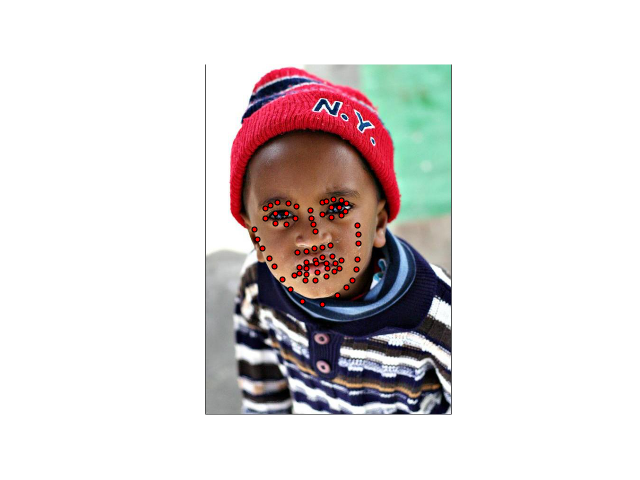

In [8]:
"""
Step 3: Calculate the quality of the fit of each of the three methods by reprojecting the original object 
points through the estimated camera. Then compare with the actual 2D correspondences.
"""
rp_is, err_solver, me_solver = calculate_reprojection_error(cmat_copy, rvec_solver, tvec_solver,
                                                    dc_copy, corres_3d, corres_2d, 
                                                    num_landmarks)
print('Iterative solver:')
print('Total error: ', err_solver, 'Mean error: ', me_solver)
show_image_with_landmarks(f, rp_is)

rcc, err_calib, me_calib = calculate_reprojection_error(cmat_cc, rvec_cc, tvec_cc, distCoeffs,
                                                  corres_3d, corres_2d, num_landmarks)
print('Camera calibrator:')
print('Total error: ', err_calib, 'Mean error: ', me_calib)
show_image_with_landmarks(f, rcc)


rp_ran, err_ran, me_ran = calculate_reprojection_error(cmat_copy, rvec_ran, tvec_ran, dc_copy,
                                                  corres_3d, corres_2d, num_landmarks)
print('RanSac:')
print('Total error: ', err_ran, 'Mean error: ', me_ran)
show_image_with_landmarks(f, rp_ran)

<IPython.core.display.Javascript object>


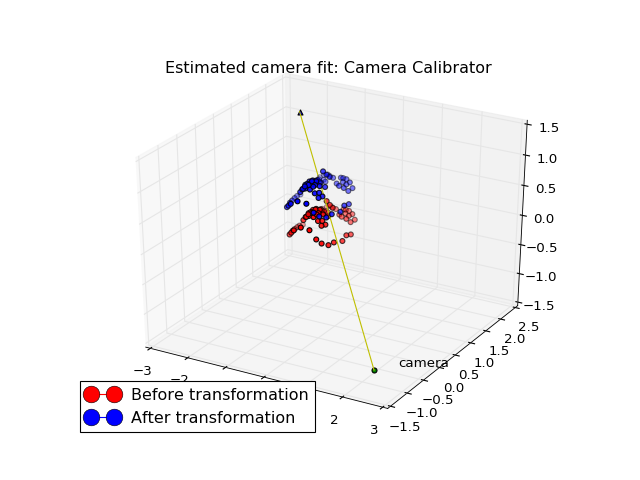

<IPython.core.display.Javascript object>


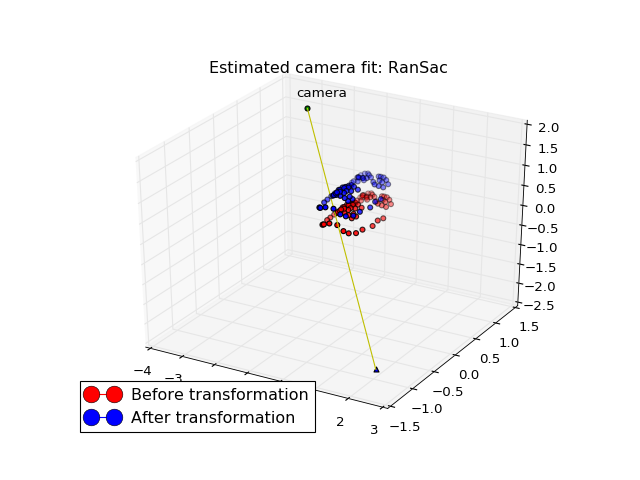

In [11]:
"""
Step 3.1.1: Change viewpoint
Option 1:
Transform landmarks in 3D, hold camera stationary
"""
# Bring face closer to the camera
mod_3d = ct_translate(corres_3d, [0, 0, +.5])
# Rotate along x to make chin bigger - pitch -ve
mod_3d = ct_rotate(mod_3d, 5, 0, 0)
plot_compare_3d_landmarks(corres_3d, mod_3d, tvec_cc, rvec_cc, 'Camera Calibrator')
plot_compare_3d_landmarks(corres_3d, mod_3d, tvec_ran, rvec_ran, 'RanSac')

Reprojection on to the image after 3D transform.


<IPython.core.display.Javascript object>


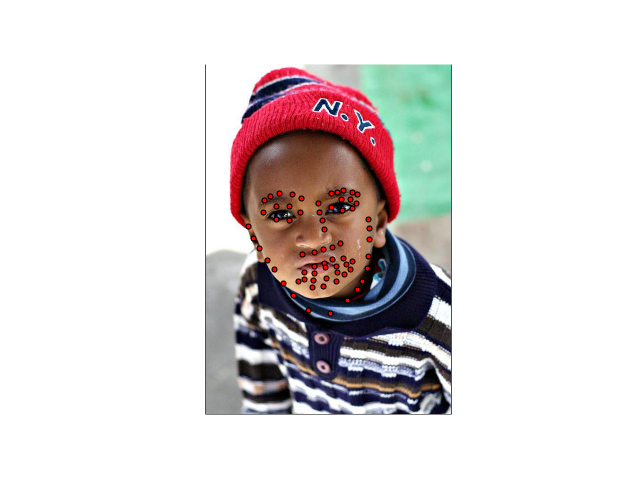

In [12]:
"""
Step 3.1.2: Reproject the transformed 3D landmarks through the camera to determine change in 2D.
Note for the purpose of analysis, I'll stick to using the camera parameters estimated by Ransac from
now on. The operations are anyway indepdent of the camera matrices.
"""
rt_proj, j = cv2.projectPoints(mod_3d, rvec_ran, tvec_ran, cmat_cc, distCoeffs)
rt_proj = np.reshape(rt_proj, (rt_proj.shape[0], 2))
print('Reprojection on to the image after 3D transform.')
show_image_with_landmarks(face, rt_proj)

In [50]:
"""
Function block: Sparse to Dense flow conversion. 
Functions that help estimate the flow vectors (u, v) for the entire image from the flow vectors
of the landmarks.
"""

from scipy.interpolate import Rbf
import scipy.ndimage

# Give importance to landmarks based on closeness. The closer a landmark is, the more it contributes to the
# flow of a point. Only closest 'candidate_count' landmark neighbours are considered.
def weighted_cordinates(x, y, landmarks, num_landmarks):
    dist = []
    candidate_count = 5
    for i in range(num_landmarks):
        euc_dist = scispat.distance.euclidean([x, y], landmarks[i, :])
        inv_dist = 1/euc_dist
        dist.append(inv_dist)
    sorted_indices = np.argsort(dist)
    dist = np.asarray(dist, dtype='float32')
    dist[np.where(sorted_indices > candidate_count)] = 0
    # Do this in the end
    dist = dist/np.sum(dist)
    return dist


def is_cordinate_a_landmark(x, y, lm, n):
    for i in range(n):
        if x==lm[i, 0] and y==lm[i, 0]:
            found = True
            break
        else:
            found = False
    return found

# Returns the flow at every point x, y on the 2D image given the landmarks and their flow vectors
def get_flow_at_point(x, y, landmarks, num_landmarks, flow_vec):
    if is_cordinate_a_landmark(x, y, landmarks, num_landmarks):
        wt_vec = weighted_cordinates(x, y, landmarks, num_landmarks)
        flow_x = np.dot(wt_vec, flow_vec[:, 0])
        flow_y = np.dot(wt_vec, flow_vec[:, 1])
        flow = [flow_x, flow_y]
    else:
        index = 0
        for i in range(num_landmarks):
            if (landmarks[i, 0] == x) and (landmarks[i, 1] == y):
                index = i
                break
        flow = flow_vec[i, :]
    return flow

# Setup the sparse flow matrix of dimension width * height * 2 containing U, V values of the landmarks.
def setup_sparse_flow(flow_vectors, landmarks, image_dim):
    # Initialize empty image
    flow_img = np.zeros((image_dim[0], image_dim[1], 2))
    num_landmarks = landmarks.shape[0]
    rounded_landmarks = np.round(landmarks)

    for nl in range(num_landmarks):
        flow_img[int(rounded_landmarks[nl, 1]), int(rounded_landmarks[nl, 0]), :] = flow_vectors[nl, :]
    
    return flow_img


# A custom KNN wrapper for obtaining a dense landmark flows from sparse flows
def sparse_to_dense_flow_knn(sparse_flow, projections, num_landmarks, flow_vec):
    rounded_proj = np.round(projections)
    for i in range(sparse_flow.shape[0]):
        for j in range(sparse_flow.shape[1]):
            sparse_flow[i, j, :] = get_flow_at_point(i, j, rounded_proj, num_landmarks, flow_vec)
    # Gaussian smooth result
    sparse_flow[:, :, 0] = scipy.ndimage.filters.gaussian_filter(sparse_flow[:, :, 0], 4)
    sparse_flow[:, :, 1] = scipy.ndimage.filters.gaussian_filter(sparse_flow[:, :, 1], 4)
    return sparse_flow

# Cubic interpolation of 2D flows with Neumann boundary conditions: i.e. flow at the boundary of the image 
# is zero. Interpolation is done with an RBF kernel.
def interpolate_flow_2d(flow_vector, proj, size):
    tx = np.arange(0, size[0], 1)
    ty = np.arange(0, size[1], 1)
    x_grid, y_grid = np.meshgrid(tx, ty)
    num_pts = proj.shape[0]

    bound_x = np.zeros(num_pts+4)
    bound_y = np.zeros(num_pts+4)
    bound_x[0:num_pts] = proj[:, 0]
    bound_y[0:num_pts] = proj[:, 1]
    bound_x[-2] = size[0]
    bound_x[-4] = size[0]
    bound_y[-1] = size[1]
    bound_y[-2] = size[1]
    
    bound_flow = np.zeros((num_pts+4, 2))
    bound_flow[0:num_pts, :] = flow_vector[:]
    bound_flow[-1:-3, :] = 0
#     print(bound_x, proj[:, 0])
#     print(bound_y, proj[:, 1])
#     print(bound_flow, flow_vector)
    rbf_x = Rbf(bound_x, bound_y, bound_flow[:, 0], function='cubic')
    rbf_y = Rbf(bound_x, bound_y, bound_flow[:, 1], function='cubic')
    
    r1 = rbf_x(x_grid, y_grid)
    r2 = rbf_y(x_grid, y_grid)

    return r1, r2


# Iterative weighted averaging - Needs fixing
def iterative_weight_average(sparse_flow, landmarks, num_iter, mask_dim=5, stride=1):
    res = np.array(sparse_flow, dtype='float32')
    rounded_landmarks = np.asarray(np.round(landmarks), dtype='int')
    width = sparse_flow.shape[0]
    height = sparse_flow.shape[1]
    
    for t in range(num_iter):
        for i in range(mask_dim, width, stride):
            for j in range(mask_dim, height, stride):
                if not is_cordinate_a_landmark(i, j, landmarks, landmarks.shape[0]):
                    tmp = np.sum(res[i-mask_dim:i+mask_dim, j-mask_dim:j+mask_dim, :])
                    cnt = np.count_nonzero(res[i-mask_dim:i+mask_dim, j-mask_dim:j+mask_dim, :])
                    if cnt == 0:
                        cnt = 1 
                    res[i, j, :] = tmp/cnt
    return res

In [51]:
"""
In progress: Dense flow vectors can also be estimated by iteratively solving the diffusion equation. This is a 
test block of how the flow field would look if the flow vectors of the landmarks diffused throughout the image
like heat.
"""
def diffusion_simulation(initial_conditions, num_iters, diff_coeff):
    # Time and spatial resolutions
    dx = 1
    dy = 1
    dt = 1
    
    # Spatial dimension
    x_dim = initial_conditions.shape[0]
    y_dim = initial_conditions.shape[1]
    
    # Number of time steps
    n_iter = num_iters
    
    sol = np.zeros((x_dim, y_dim, 2))
    
    # Setup initial conditions
#     sol[90:100, 90:100, 0] = 50 #np.random.randint(50, size=(10, 10))
#     sol[0:20, 0:20, 0] = 30 #np.random.randint(20, size=(20, 20))
#     sol[90:100, 0:20, 0] = 100 #np.random.randint(200, size=(10, 20))
    sol[:, :, 0] = initial_conditions
    
    # Iterative solution
    for t in range(1, n_iter):
        prev = 0
        curr = 1
        diff_x = sol[2:x_dim, 1:y_dim-1, prev]-2*sol[1:x_dim-1,1:y_dim-1, prev] + sol[0:x_dim-2, 1:y_dim-1, prev]
        diff_x = diff_x/np.power(dx, 2)
        
        diff_y = sol[1:x_dim-1, 2:y_dim, prev]-2*sol[1:x_dim-1, 1:y_dim-1, prev] + sol[1:x_dim-1, 0:y_dim-2, prev]
        diff_y = diff_y/np.power(dy, 2)
        
        # Update solution for time step t
        sol[1:x_dim-1, 1:y_dim-1, curr] = sol[1:x_dim-1, 1:y_dim-1, prev] + diff_coeff*dt*(diff_x + diff_y)
        sol[:, :, prev] = sol[:, :, curr]
    
    # plot results
#     fig = pyplot.figure()
#     pyplot.axis([0, x_dim, 0, y_dim])
#     pyplot.pcolor(sol[:, :, 1], cmap='jet', origin='upper')
#     pyplot.axis('off')
#     pyplot.show()
    return sol[:, :, 1]

In [67]:
"""
Function block: Warping and post processing
Given an input image and a dense flow field, this function warps the input according to the flow at 
every point.
"""
def warp_img(input_img, flow_field):
    out_img = np.zeros(input_img.shape, dtype='uint8')
    for i in range(input_img.shape[0]):
        for j in range(input_img.shape[1]):
            x_new = int(flow_field[i, j, 1])+ i
            y_new = int(flow_field[i, j, 0]) + j
#             if (i == 102 and j == 352):
#                 print(i, j, x_new, y_new)
            if ((x_new > 0) and (x_new < input_img.shape[0])):
                if ((y_new > 0) and (y_new < input_img.shape[1])):
                    out_img[x_new, y_new, :] = input_img[i, j, :]

    return out_img


def auto_inpaint(img, radius):
    mask = (img == [0, 0, 0])
    mask = mask[:, :, 0] * 1
    mask = np.asarray(mask, dtype='uint8')
#     print(mask.shape)
#     pyplot.imshow(mask)
    return cv2.inpaint(img, mask, radius, cv2.INPAINT_TELEA)

<IPython.core.display.Javascript object>


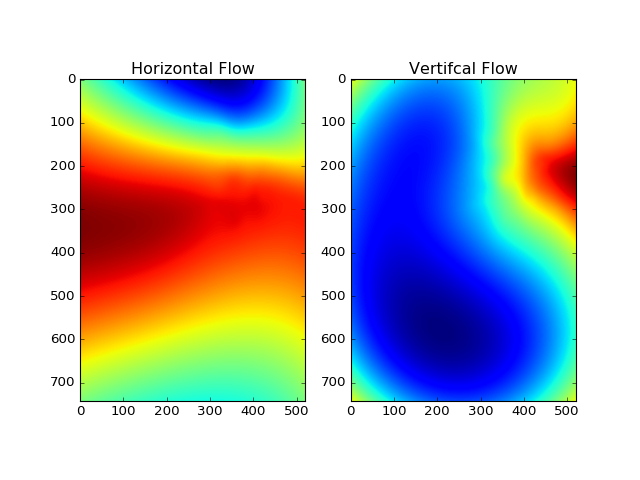

In [53]:
"""
Step 3.1.3: Estimate flow vectors for landmarks in 2D
"""
flow_rt = rt_proj - rp_ran
# Rounded projections
rp_ran_int = np.round(rp_ran)
rp_ran_int = np.array(rp_ran_int, dtype=int)
# print(flow_rt)
# Setup the sparse flow matrix
flow_img_rt = setup_sparse_flow(flow_rt, rp_ran, [f.shape[0], f.shape[1]])
"""
Sparse to dense flow conversion with any one of the above methods:
- KNN Weighted averaging
- Cubic interpolation (Preferred)
- Diffusion
- Iterative weighted averaging
"""
# flow_img_rt = sparse_to_dense_flow_knn(flow_img_rt, rcc, num_landmarks, flow_rt)
tmpx, tmpy = interpolate_flow_2d(flow_rt, rp_ran_int, [f.shape[0], f.shape[1]])
flow_img_rt[:, :, 0] = tmpx.transpose()
flow_img_rt[:, :, 1] = tmpy.transpose()
# flow_img_rt = iterative_weight_average(flow_img_rt, rcc, 1)
show_flow_field(flow_img_rt)

<IPython.core.display.Javascript object>


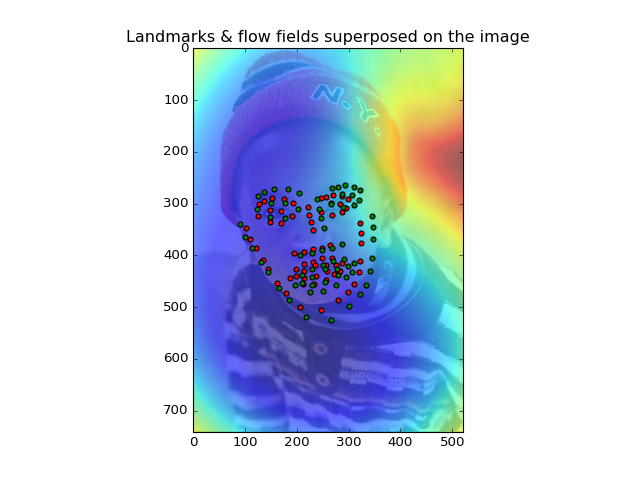

In [58]:
fig = pyplot.figure()
pyplot.title('Landmarks & flow fields superposed on the image')
pyplot.imshow(face, alpha=0.5)
pyplot.scatter(rp_ran[:, 0], rp_ran[:, 1], c='r')
pyplot.scatter(rt_proj[:, 0], rt_proj[:, 1], c='g')
pyplot.imshow(flow_img_rt[:, :, 1], alpha=0.6)
pyplot.show()
# pyplot.imshow(flow_img[:, :, 1])
# pyplot.show()

<IPython.core.display.Javascript object>


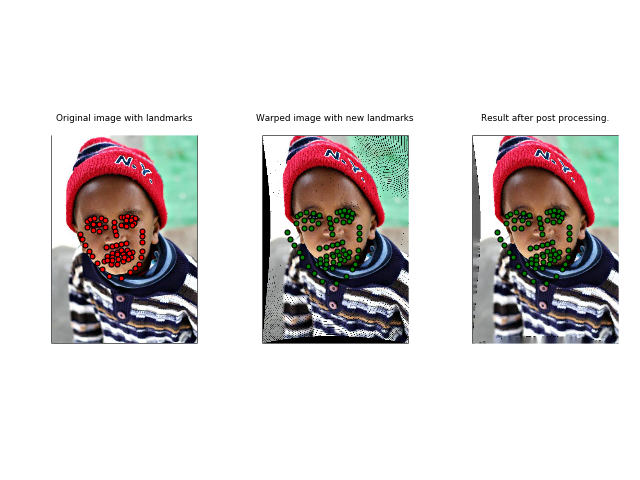

In [68]:
tr_img_rt = warp_img(f, flow_img_rt)
# tr_img_rt = scipy.ndimage.filters.gaussian_filter(tr_img_rt, 2)
res = auto_inpaint(tr_img_rt, 5)

fig = pyplot.figure()
ax1 = fig.add_subplot(1, 3, 1)
pyplot.imshow(f)
ax1.set_title('Original image with landmarks', fontsize=8)
ax1.scatter(rp_ran[:, 0], rp_ran[:, 1], c='r')
ax1.axis('off')

ax2 = fig.add_subplot(1, 3, 2)
pyplot.imshow(tr_img_rt)
ax2.set_title('Warped image with new landmarks', fontsize=8)
ax2.axis('off')
ax2.scatter(rt_proj[:, 0], rt_proj[:, 1], c='g')

ax3 = fig.add_subplot(1, 3, 3)
pyplot.imshow(res)
ax3.set_title('Result after post processing.', fontsize=8)
ax3.axis('off')
ax3.scatter(rt_proj[:, 0], rt_proj[:, 1], c='g')

fig.tight_layout()
pyplot.show()

<IPython.core.display.Javascript object>


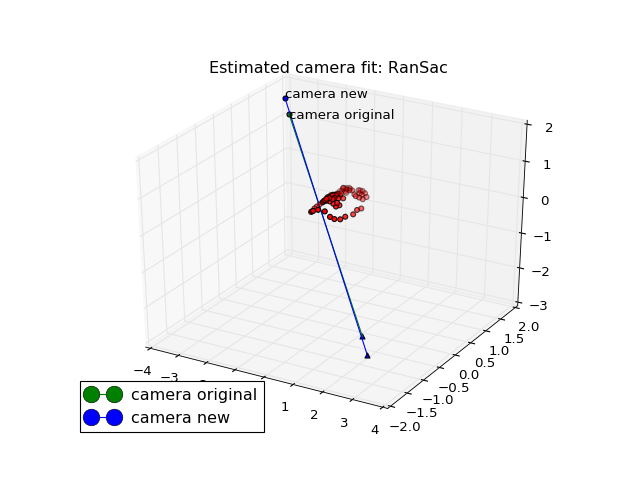

In [62]:
"""
Step 3.2.1:
Option 2:
Alternatively, move the camera around such that the perspective changes.
"""
tvec_new = np.copy(tvec_ran)
rvec_new = np.copy(rvec_ran)
cmat_new = np.copy(cmat_cc)
dist_new = np.copy(distCoeffs)

tvec_new[0] += -.5
tvec_new[1] += .3
tvec_new[2] += .2

plot_compare_3d_cameras(corres_3d, tvec_ran, rvec_ran, tvec_new, rvec_new, 'RanSac')

# p_new, j = cv2.projectPoints(corres_3d, rvec_new, tvec_new, cmat_new, dist_new)
# p_new = np.reshape(p_new, (num_landmarks, 2))
# show_image_with_landmarks(face, p_new)

Reprojection on to the image after camera displacement:


<IPython.core.display.Javascript object>


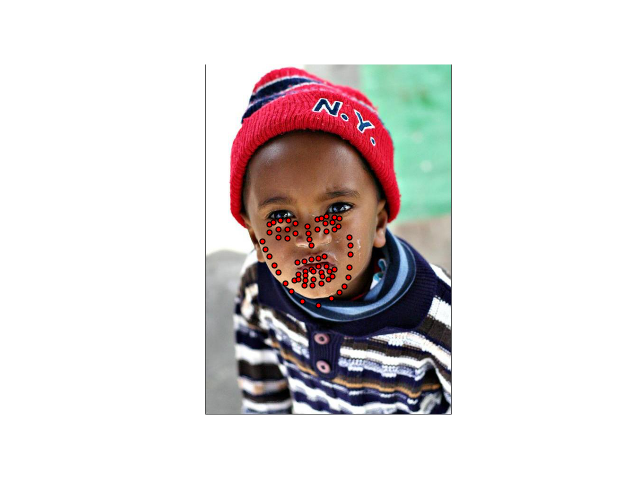

In [63]:
"""
Step: 3.2.1: Reproject t he original 3D landmarks through the new camera to get new projections in 2D. As before,
I use the camera parameters estimated by the camera calibrator
"""
ct_proj, j = cv2.projectPoints(corres_3d, rvec_new, tvec_new, cmat_new, dist_new)
ct_proj = np.reshape(ct_proj, (ct_proj.shape[0], 2))
print('Reprojection on to the image after camera displacement:')
show_image_with_landmarks(face, ct_proj)

<IPython.core.display.Javascript object>


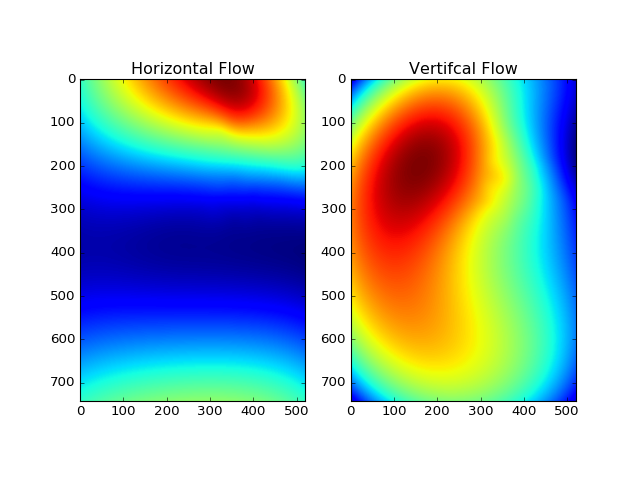

In [64]:
"""
Step 3.2.2: Estimate sparse landmark flow in 2D.
"""
flow_vec_ct = ct_proj - rp_ran
flow_img_ct = np.zeros((f.shape[0], f.shape[1], 2), dtype='float32')
flow_img_ct = setup_sparse_flow(flow_vec_ct, rp_ran, [f.shape[0], f.shape[1]])

# Sparse to dense flow. Recollect that 'rp_ran_int' holds the integer reprojected landmarks.
tmpx, tmpy = interpolate_flow_2d(flow_vec_ct, rp_ran_int, [f.shape[0], f.shape[1]])
flow_img_ct[:, :, 0] = tmpx.transpose()
flow_img_ct[:, :, 1] = tmpy.transpose()

# print(flow_vec[0, :])
# print(flow_img[rcc_int[0, 0], rcc_int[0, 1], :])
# print(flow_vec)
# pyplot.imshow(flow_img[:, :, 1], cmap='Greys')
# pyplot.show()

show_flow_field(flow_img_ct)

<IPython.core.display.Javascript object>


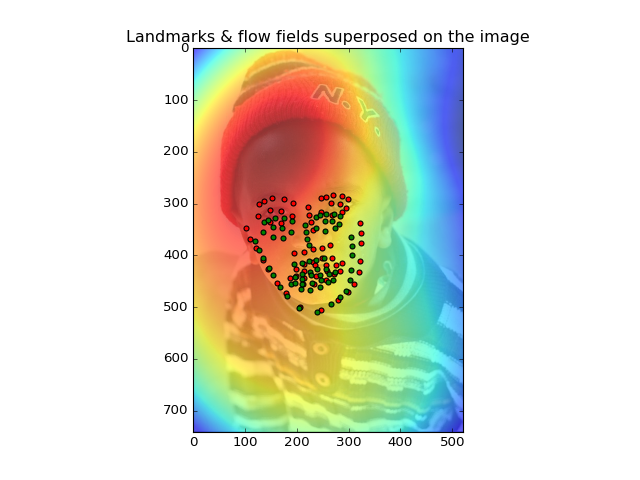

In [66]:
fig = pyplot.figure()
pyplot.title('Landmarks & flow fields superposed on the image')
pyplot.imshow(face, alpha=0.5)
pyplot.scatter(rp_ran[:, 0], rp_ran[:, 1], c='r')
pyplot.scatter(ct_proj[:, 0], ct_proj[:, 1], c='g')
pyplot.imshow(flow_img_ct[:, :, 1], alpha=0.6)
pyplot.show()

<IPython.core.display.Javascript object>


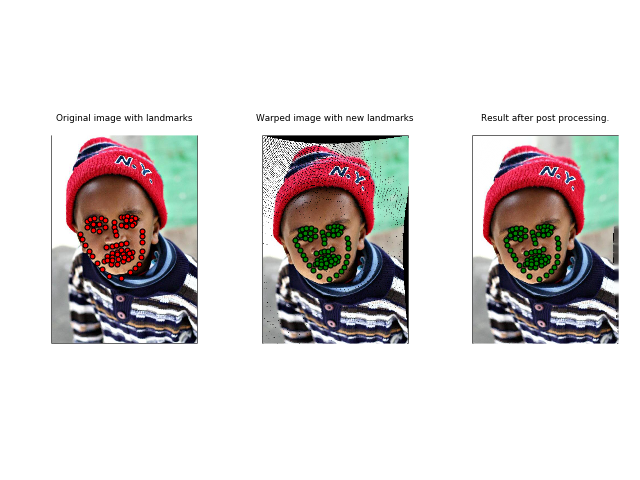

In [69]:
"""
Step 3.2.3: Warp image from the estimated Dense flow
"""
tr_img_ct = warp_img(f, flow_img_ct)
res_ct = auto_inpaint(tr_img_ct, 5)

fig = pyplot.figure()
ax1 = fig.add_subplot(1, 3, 1)
pyplot.imshow(f)
ax1.set_title('Original image with landmarks', fontsize=8)
ax1.scatter(rp_ran[:, 0], rp_ran[:, 1], c='r')
ax1.axis('off')

ax2 = fig.add_subplot(1, 3, 2)
pyplot.imshow(tr_img_ct)
ax2.set_title('Warped image with new landmarks', fontsize=8)
ax2.axis('off')
ax2.scatter(ct_proj[:, 0], ct_proj[:, 1], c='g')

ax3 = fig.add_subplot(1, 3, 3)
pyplot.imshow(res_ct)
ax3.set_title('Result after post processing.', fontsize=8)
ax3.axis('off')
ax3.scatter(ct_proj[:, 0], ct_proj[:, 1], c='g')

fig.tight_layout()
pyplot.show()

<IPython.core.display.Javascript object>


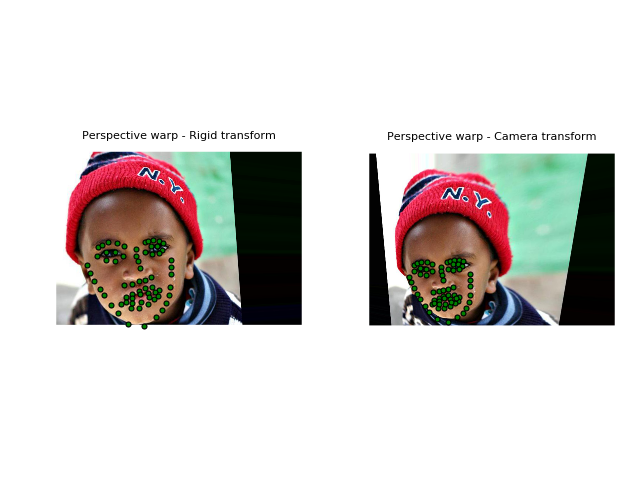

In [74]:
"""
Alternate warp option:
From a subset of the original and transformed landmarks, solve linear system of equations 
to get a perspective transform matrix.
Apply this to every point in the original image.
"""
# For the rigid transform
trans_mat_rt = cv2.getPerspectiveTransform(np.array([rp_ran[0, :], rp_ran[17, :], rp_ran[28, :], rp_ran[58, :]]), np.array([rt_proj[0, :], rt_proj[17, :], rt_proj[28, :], rt_proj[58, :]]))
# print(trans_mat_rt.shape)
warp_result_rt = cv2.warpPerspective(f, trans_mat_rt, dsize=(f.shape[0], f.shape[1]), borderMode=cv2.BORDER_REPLICATE)
# For the camera transfrom
trans_mat_ct = cv2.getPerspectiveTransform(np.array([rp_ran[0, :], rp_ran[17, :], rp_ran[28, :], rp_ran[58, :]]), np.array([ct_proj[0, :], ct_proj[17, :], ct_proj[28, :], ct_proj[58, :]]))
# print(trans_mat_ct.shape)
warp_result_ct = cv2.warpPerspective(f, trans_mat_ct, dsize=(f.shape[0], f.shape[1]), borderMode=cv2.BORDER_REPLICATE)

fig = pyplot.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(warp_result_rt)
ax1.set_title('Perspective warp - Rigid transform', fontsize=10)
pyplot.scatter(rt_proj[:, 0], rt_proj[:, 1], c='g')
ax1.axis('off')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(warp_result_ct)
ax2.set_title('Perspective warp - Camera transform', fontsize=10)
pyplot.scatter(ct_proj[:, 0], ct_proj[:, 1], c='g')
ax2.axis('off')

pyplot.tight_layout()
pyplot.show()

In [ ]:
# KNN smooth flow - example
flow_img = sparse_to_dense_flow_knn(flow_img, rcc, num_landmarks, flow_vec)
show_flow_field(flow_img)

<IPython.core.display.Javascript object>


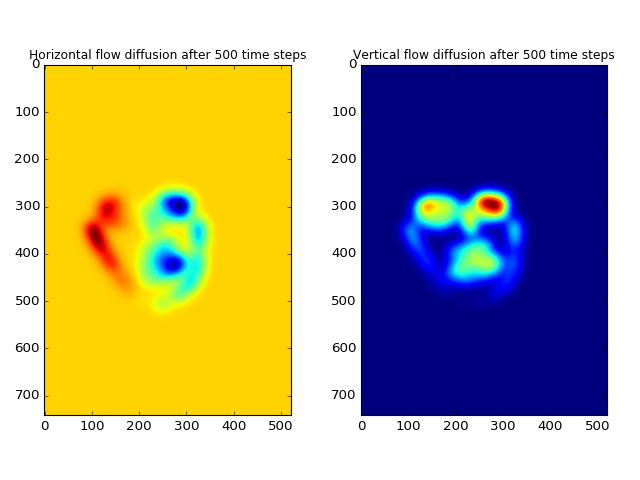

In [75]:
import scipy.ndimage
# Diffusion smoothing example:
flow_img_diff = np.zeros((f.shape[0], f.shape[1], 2), dtype='float32')
flow_img_diff = setup_sparse_flow(flow_vec_ct, rp_ran, [f.shape[0], f.shape[1]])
flow_img_diff[:, :, 0] = diffusion_simulation(flow_img_diff[:, :, 0], 500, .20)
flow_img_diff[:, :, 1] = diffusion_simulation(flow_img_diff[:, :, 1], 500, .20)

fig = pyplot.figure()
ax1 = fig.add_subplot(1, 2, 1)
# ax1.imshow(f, alpha=.9)
ax1.imshow(flow_img_diff[:, :, 0])
ax1.set_title('Horizontal flow diffusion after 500 time steps', fontsize=11)
ax2 = fig.add_subplot(1, 2, 2)
pyplot.imshow(flow_img_diff[:, :, 1], origin='upper')
ax2.set_title('Vertical flow diffusion after 500 time steps', fontsize=11)
pyplot.tight_layout()
pyplot.show()

In [80]:
"""
Saving stuff
"""
from PIL import Image

im = Image.fromarray(res)
im.save('rigid_transform_final_result.jpg')

im = Image.fromarray(res_ct)
im.save('camera_transform_final_result.jpg')

im = Image.fromarray(warp_result_rt)
im.save('warp_rigid_final_result.jpg')

im = Image.fromarray(warp_result_ct)
im.save('warp_camera_final_result.jpg')